In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, kstest
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import joblib

In [2]:
df_vendas = pd.read_csv('./dataset/dataset_vendas.csv')

In [3]:
df_vendas_eda = df_vendas.copy()
df_vendas_bucketing = df_vendas.copy()

In [4]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tempo_de_experiencia  100 non-null    int64  
 1   numero_de_vendas      100 non-null    int64  
 2   fator_sazonal         100 non-null    int64  
 3   receita_em_reais      100 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 3.3 KB


### EDA

In [5]:
df_vendas_eda.head(10)

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
0,36,21,5,2639.886941
1,74,44,10,4707.322227
2,38,44,4,5910.035131
3,52,62,6,6130.742546
4,97,56,2,7516.457681
5,67,70,10,1247.882324
6,119,69,2,3485.606208
7,66,62,2,2773.987427
8,68,96,3,4177.919578
9,106,42,2,4719.691069


In [6]:
# nenhum valor ausente
df_vendas_eda.isna().sum()

tempo_de_experiencia    0
numero_de_vendas        0
fator_sazonal           0
receita_em_reais        0
dtype: int64

In [7]:
df_vendas_eda.describe()

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
count,100.000000,100.000000,100.000000,100.000000
mean,64.490000,54.490000,5.820000,5112.941924
std,32.397935,25.307201,2.836914,2544.731052
min,1.000000,10.000000,1.000000,1133.363948
25%,38.750000,37.500000,4.000000,2800.660516
50%,64.500000,52.500000,5.000000,4953.770034
75%,93.000000,70.500000,8.000000,7079.500163
max,119.000000,100.000000,10.000000,9941.016458


#### Análise de outliers

<Figure size 1000x600 with 0 Axes>

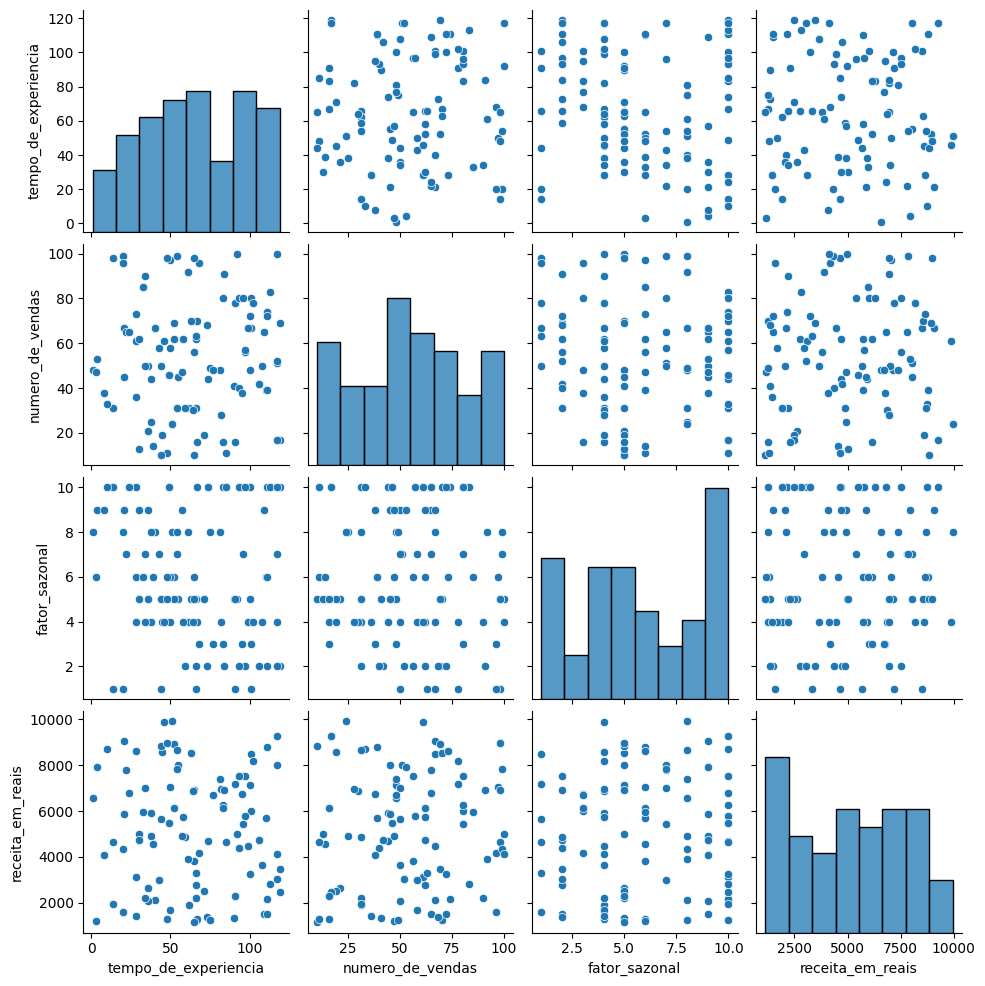

In [8]:
plt.figure(figsize=(10, 6))
sns.pairplot(df_vendas_eda)

#### Correlação entre Variáveis

<Axes: >

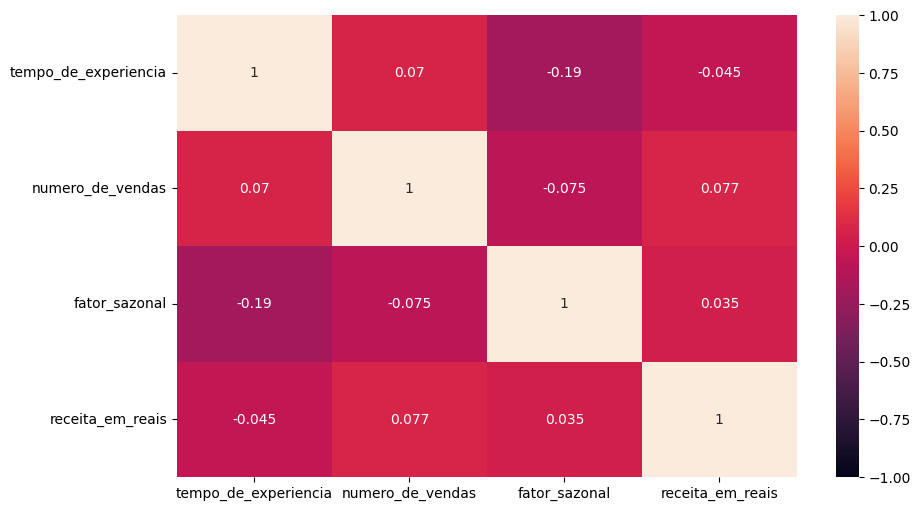

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(df_vendas_eda.corr('spearman'), vmin=-1, vmax=1, annot=True)

<Axes: >

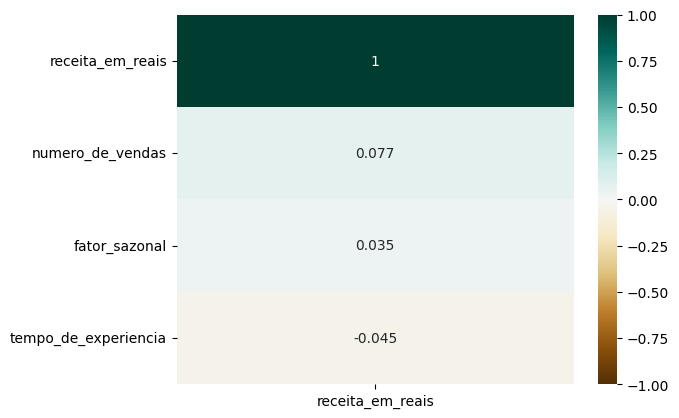

In [10]:
sns.heatmap(df_vendas_eda.corr('spearman')[['receita_em_reais']].sort_values(by='receita_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

### Treinamento do Modelo - Linear

In [11]:
X = df_vendas.drop(columns=['receita_em_reais', 'fator_sazonal'], axis=1)
y = df_vendas['receita_em_reais']

kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [12]:
kf

KFold(n_splits=5, random_state=51, shuffle=True)

In [13]:
# Pipeline

colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas']

transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

model_regr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# armazenar RMSE de treino e teste
rmse_scores_fold_train = []
rmse_scores_fold_test = []

# armazenar r2score de teste
r2score_fold_test = []

# armazenar resíduos
residuos = []

# armazenar predições
y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_regr.fit(X_train, y_train)

    # Predições nos conjuntos de treino e teste
    y_train_pred = model_regr.predict(X_train)
    y_test_pred = model_regr.predict(X_test)

    # RMSE para os conjuntos de treino e teste
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # r2score para conjunto de teste
    r2score_test = r2_score(y_test, y_test_pred)

    # residuos
    residuos_test = np.array(y_test - y_test_pred)

    # armazenar métricas de iteração da lista
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_test.append(rmse_test)
    r2score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total = np.array(y_pred_total).reshape(-1)

# calcula as médias das métricas
rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_test)
percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final
r2score_test_final = np.mean(r2score_fold_test)
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

### Análise de Métricas

In [14]:
print(f"RMSE de treino: {rmse_train_final}")
print(f"RMSE de teste: {rmse_test_final}")
print(f"% dif. RMSE treino e teste: {percentual_rmse_final}")
print(f"r2score de teste: {r2score_test_final}")

RMSE de treino: 2506.4020236861
RMSE de teste: 2646.215898584393
% dif. RMSE treino e teste: 0.055782701089856376
r2score de teste: -0.13451763390799448


### Treinar Modelo - Polinomial

In [15]:
X = df_vendas.drop(columns=['receita_em_reais'], axis=1)

In [16]:
# graus_polymonial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
graus_polymonial = [1]


rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polymonial:

    # Pipeline
    colunas_numericas = ['tempo_de_experiencia', 'numero_de_vendas', 'fator_sazonal']

    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )

    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    model_poly = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
    ])

    # armazenar RMSE de treino e teste
    rmse_scores_fold_train = []
    rmse_scores_fold_test = []

    # armazenar r2score de teste
    r2score_fold_test = []

    # armazenar resíduos
    residuos = []

    # armazenar predições
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_poly.fit(X_train, y_train)

        # Predições nos conjuntos de treino e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        # RMSE para os conjuntos de treino e teste
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # r2score para conjunto de teste
        r2score_test = r2_score(y_test, y_test_pred)

        # residuos
        residuos_test = np.array(y_test - y_test_pred)

        # armazenar métricas de iteração da lista
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_test.append(rmse_test)
        r2score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total = np.array(y_pred_total).reshape(-1)

    # calcula as médias das métricas
    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_test)
    percentual_rmse_final = (rmse_test_final - rmse_train_final) / rmse_train_final
    r2score_test_final = np.mean(r2score_fold_test)
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    percentual_rmse_values.append(percentual_rmse_final)
    r2score_test_values.append(r2score_test_final)


### Validação de Métricas

In [17]:
print(f"RMSE de Treino: {rmse_train_final}")
print(f"RMSE de Teste: {rmse_test_final}")
print(f"Percentual de RMSE de Treino e Teste: {percentual_rmse_final}")
print(f"r2score de Teste: {r2score_test_final}")

RMSE de Treino: 2503.7778480738625
RMSE de Teste: 2657.652017969138
Percentual de RMSE de Treino e Teste: 0.06145679817945894
r2score de Teste: -0.1444571756461522


*Resultado:*
Com base nas métricas dos dois modelos, posso afirmar que o modelo linear se saiu melhor do que o modelo polinômial diante do contexto do exercicio.

In [18]:
# Predição
input_features = {
    'tempo_de_experiencia': 95,
    'numero_de_vendas': 50
}

pred_df = pd.DataFrame(input_features, index=[1])

In [19]:
model_regr.predict(pred_df)

array([4995.26957292])

In [20]:
joblib.dump(model_regr, './modelo_receita.pkl')

['./modelo_receita.pkl']